# DATATHON 
##### Detecting Pricing Anomalies
### IE MBD-O2


![title](hotelbed.jpg)

## Approach Abstract

Detecting outliers or anomalies in pricing from the bookings data is an unsupervised learning problem. We will approach the problem with a three-pronged flow:
##### 1. Tag Explicit Errors and Meaningless Values
##### 2. Remove extreme values contrary to domain standards
##### 2. Check for statistical outliers based on calculated Outlier Score
##### 3. Cluster similar bookings based on pricipal components and detect statistical outliers


<img src="Intro.png" alt="Drawing" style="width: 500px;"/>


We proceed with the above approach while forming 2 basic assumption/hypothesis:
1. clusters or features that have higher standard deviations, kurtosis or extreme values are more likely to contain anomalies
2. Total anomalies will probably not be higher than 1% of the data set

The above approach is implemented by exploring the data set and at each level we create sub-sets of the data that are likely to be anomalies. In the end we combine all of these and create the final tag = 1 for anomalies, 0 for genuine. 

## Table of contents
1. [Initialization](#initialization)
2. [Basic Data Exploration,Feature Creation and Transformation](#bda)
3. [Feature Analysis](#fa)
    1. [ContractID](#contID)
    2. [Star Rating](#star)
    3. [Room Type](#room)
    4. [Arrival Month](#month)
    5. [Category](#cat)
    6. [Meal Basis](#meal)
    7. [Contract Type](#contract)
    8. [Other Date Variables](#date)
    9. [Time Variables](#time)
    10. [City](#city)
    11. [Hotel Key](#hotel)
4. [Data Set Transformation](#transformation)
5. [Outlier/Anomaly Detection](#outlierDetection)    
    1. [Statistical and Visual Approach](#stat)
    2. [Clustering and Regression Approach](#cluster)
5. [Anomaly Labeling and Submission](#submit)

### Initialization <a name="initialization"></a>

In [2]:
# importing primary libraries
import numpy as np
import pandas as pd
from collections import Counter
import datetime as dt
import workdays
import glob
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)


%matplotlib inline

In [3]:
# reading data set
df = pd.read_csv('/Users/miketondu/Dropbox/Data Science/IE Big Data/MODULE III/DATATHON/DATATHON_STU.csv', index_col= 0)
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,departure_date,total_cost,star_rating,row_id
0,-8267178856752109189,-2268968424949879745,-7057068746275558393,1,ST-1,NOR,DBL,BB,2018-05-15,2018-12-27,2019-01-02,10547.630400,4,0
1,-1685290188623826844,-6660022717883519295,-2196849751944447984,0,ST,NRF,DBT,RO,2018-05-15,2018-07-21,2018-07-24,488.373126,3,1
2,-7840397635682426109,-5150800997425879880,-8665482707194037246,0,PP,NONE,DBL,BB,2018-05-15,2018-08-29,2018-09-02,13510.070688,5,2
3,-6857665811800939251,-7369482760620721804,8416789533981337661,1,ST,NOR,TWN,BB,2018-05-15,2018-05-24,2018-05-27,5103.259200,3,3
4,-7182313616126400607,-8424448225994711484,-886133892282086847,6,ST,OPQ,CAB,RO,2018-05-15,2018-11-24,2018-11-29,12820.430298,4,4


In [4]:
# Checking properties of the data set
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(904779, 14)
hotel_hkey            int64
contract_id_hkey      int64
id_hkey               int64
city_code             int64
category_room        object
contract_type        object
room_type            object
meal_basis           object
creation_date        object
arrival_date         object
departure_date       object
total_cost          float64
star_rating          object
row_id                int64
dtype: object
hotel_hkey             0
contract_id_hkey       0
id_hkey                0
city_code              0
category_room          0
contract_type          0
room_type              0
meal_basis             0
creation_date          0
arrival_date           0
departure_date         0
total_cost          8814
star_rating            0
row_id                 0
dtype: int64


### Basic Data Exploration, Feature Creation and Transformation <a name="bda"></a> 
We begin with exploring the data set. We first remove the obvious anomalies (step 1 of our approach) which are the Nulls and negetive prices

In [5]:
# Imputing nulls, negatives and zero values for costs into an 'anomaly' Data Frame.
df_anomaly1 = df.loc[(df.total_cost <= 0) | (df.total_cost.isnull()),:] 
df = df.loc[df.total_cost.notnull(), :] 
df = df.loc[df.total_cost > 0, :]
df_anomaly1.shape

(8821, 14)

Date variable has a lot of features hidden, we extract them and create new feature variables such as month, day etc for arrival, departure and booking

In [6]:
# Function definition for extracting days from delta time
def extractDays(td):
    return td.days

# Function to calculate working days between 2 dates
def cal_weekdays(a):
    return(workdays.networkdays(pd.to_datetime(a[0]),pd.to_datetime(a[1])))

In [7]:
# Create basic features out of the provided date variable
df["creation_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).month
df["creation_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).day
df["creation_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['creation_date'])).weekday

df["arrival_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).month
df["arrival_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).day
df["arrival_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['arrival_date'])).weekday

df["departure_date_month"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).month
df["departure_date_day"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).day
df["departure_date_weekday"] = pd.DatetimeIndex(pd.to_datetime(df['departure_date'])).weekday

Using the variables previously created we decided to come up with new features based on the departure_date, arrival_date and creation_date:  

'**TripNoOfDays**' the duration of the trip

'**begEnd**' tuple of arrival_date and departure_date

'**TripWorkingDays**' number of working days during the trip

'**TripWeekends**' number of weekends during the trip

'**BookingLeadTime**' Lead time between booking and start of the trip

In [8]:
df["TripNoOfDays"] = pd.DatetimeIndex(pd.to_datetime(df.departure_date)) - pd.DatetimeIndex(pd.to_datetime(df.arrival_date)) 

df.TripNoOfDays =  df.TripNoOfDays.apply(extractDays)
df.TripNoOfDays = df.TripNoOfDays + 1

df['begEnd'] = df[['arrival_date', 'departure_date']].apply(tuple, axis=1)
df["TripWorkingDays"]  = df.begEnd.apply(cal_weekdays)
df["TripWeekends"] =   df.TripNoOfDays -  df.TripWorkingDays
df.loc[df.TripWeekends < 0,'TripWeekends'] = 0

df["BookingLeadTime"] = pd.DatetimeIndex(pd.to_datetime(df.arrival_date)) - pd.DatetimeIndex(pd.to_datetime(df.creation_date)) 
df.BookingLeadTime =  df.BookingLeadTime.apply(extractDays)

In [9]:
# Create feature 'price/cost' per night
df["PricePerNight"] = df.total_cost / df.TripNoOfDays
df["PricePerNight"] = df.PricePerNight.apply(int)
df.head()

,hotel_hkey,contract_id_hkey,id_hkey,city_code,category_room,contract_type,room_type,meal_basis,creation_date,arrival_date,departure_date,total_cost,star_rating,row_id,creation_date_month,creation_date_day,creation_date_weekday,arrival_date_month,arrival_date_day,arrival_date_weekday,departure_date_month,departure_date_day,departure_date_weekday,TripNoOfDays,begEnd,TripWorkingDays,TripWeekends,BookingLeadTime,PricePerNight
0,-8267178856752109189,-2268968424949879745,-7057068746275558393,1,ST-1,NOR,DBL,BB,2018-05-15,2018-12-27,2019-01-02,10547.630400,4,0,5,15,1,12,27,3,1,2,2,7,"(2018-12-27, 2019-01-02)",5,2,226,1506
1,-1685290188623826844,-6660022717883519295,-2196849751944447984,0,ST,NRF,DBT,RO,2018-05-15,2018-07-21,2018-07-24,488.373126,3,1,5,15,1,7,21,5,7,24,1,4,"(2018-07-21, 2018-07-24)",2,2,67,122
2,-7840397635682426109,-5150800997425879880,-8665482707194037246,0,PP,NONE,DBL,BB,2018-05-15,2018-08-29,2018-09-02,13510.070688,5,2,5,15,1,8,29,2,9,2,6,5,"(2018-08-29, 2018-09-02)",3,2,106,2702
3,-6857665811800939251,-7369482760620721804,8416789533981337661,1,ST,NOR,TWN,BB,2018-05-15,2018-05-24,2018-05-27,5103.259200,3,3,5,15,1,5,24,3,5,27,6,4,"(2018-05-24, 2018-05-27)",2,2,9,1275
4,-7182313616126400607,-8424448225994711484,-886133892282086847,6,ST,OPQ,CAB,RO,2018-05-15,2018-11-24,2018-11-29,12820.430298,4,4,5,15,1,11,24,5,11,29,3,6,"(2018-11-24, 2018-11-29)",4,2,193,2136


/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


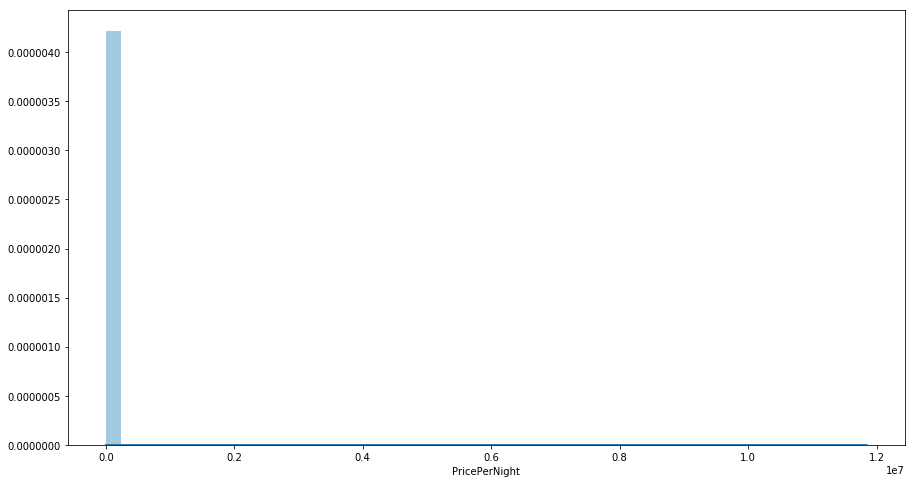

In [10]:
# Plot the distribution of 'PriceperNight' in millions
plt.figure(figsize=(15,8))
sns.distplot(df.loc[:,'PricePerNight']); 

In [11]:
# New list that comprises all the categorical variables from the Data Frame
categoricalVariables = ['city_code','category_room','contract_type','room_type','meal_basis',
                       'creation_date_month', 'creation_date_day',
                       'creation_date_weekday', 'arrival_date_month', 'arrival_date_day',
                       'arrival_date_weekday', 'departure_date_month', 'departure_date_day',
                       'departure_date_weekday','star_rating']

# Change the variable type of the previous list to 'category'
for i in categoricalVariables:
    df[i] = df[i].astype('category')
    
    
# Delete the variables we no longer need
df = df.drop(['id_hkey', 'creation_date', 'arrival_date', 'departure_date', 'begEnd', 'total_cost'], axis = 1)

#### Exploring the distribution of Variables

In [12]:
# Create two new Data Frames containing all the categorical and numerical features, respectively
categoricalVariables = df.select_dtypes(include=['category']).columns
#numericalVariables = df.select_dtypes(exclude=['int64']).columns
numericalVariables = df.select_dtypes(exclude=['category']).columns

categoricalVariables
numericalVariables

Index(['city_code', 'category_room', 'contract_type', 'room_type',
       'meal_basis', 'star_rating', 'creation_date_month', 'creation_date_day',
       'creation_date_weekday', 'arrival_date_month', 'arrival_date_day',
       'arrival_date_weekday', 'departure_date_month', 'departure_date_day',
       'departure_date_weekday'],
      dtype='object')

Index(['hotel_hkey', 'contract_id_hkey', 'row_id', 'TripNoOfDays',
       'TripWorkingDays', 'TripWeekends', 'BookingLeadTime', 'PricePerNight'],
      dtype='object')

In [13]:
#Describe all the columns
columnNames = df.columns
for i in columnNames:
    print(i)
    print(df[i].describe())

hotel_hkey
count    8.959580e+05
mean    -7.842636e+15
std      5.319222e+18
min     -9.223350e+18
25%     -4.615101e+18
50%     -5.479016e+15
75%      4.590851e+18
max      9.223359e+18
Name: hotel_hkey, dtype: float64
contract_id_hkey
count    8.959580e+05
mean     4.662727e+15
std      5.324968e+18
min     -9.223363e+18
25%     -4.599947e+18
50%      7.573991e+15
75%      4.620117e+18
max      9.223357e+18
Name: contract_id_hkey, dtype: float64
city_code
count     895958
unique         9
top            7
freq      175205
Name: city_code, dtype: int64
category_room
count     895958
unique      1320
top           ST
freq      409521
Name: category_room, dtype: object
contract_type
count     895958
unique         7
top          NOR
freq      497565
Name: contract_type, dtype: object
room_type
count     895958
unique        24
top          DBL
freq      344631
Name: room_type, dtype: object
meal_basis
count     895958
unique        17
top           BB
freq      418618
Name: meal_basis, 

In [14]:
# Drop variables that are no longer needed
categoricalVariables = categoricalVariables.drop(['category_room'])
numericalVariables = numericalVariables.drop(['row_id','hotel_hkey','contract_id_hkey'])

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'city_code')

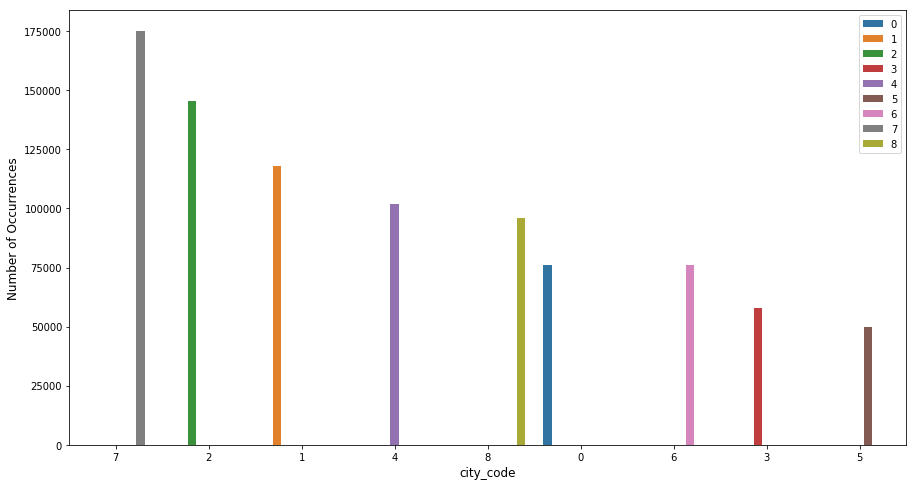

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'contract_type')

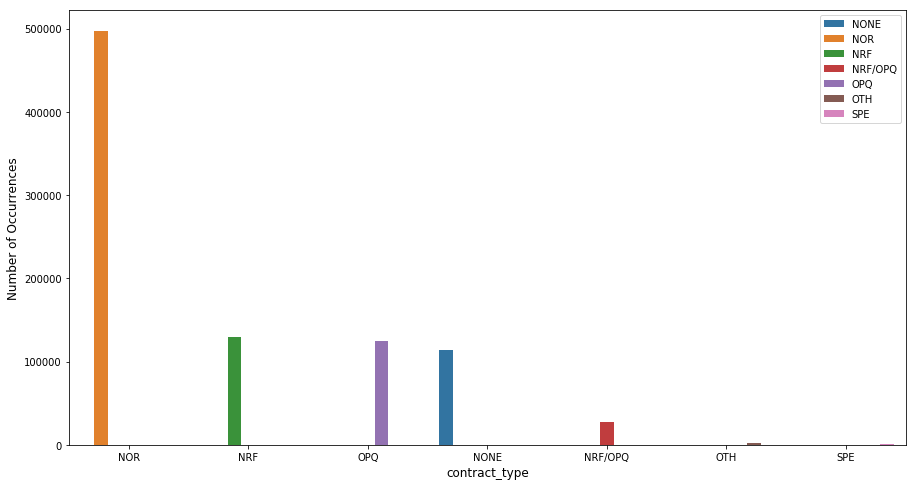

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'room_type')

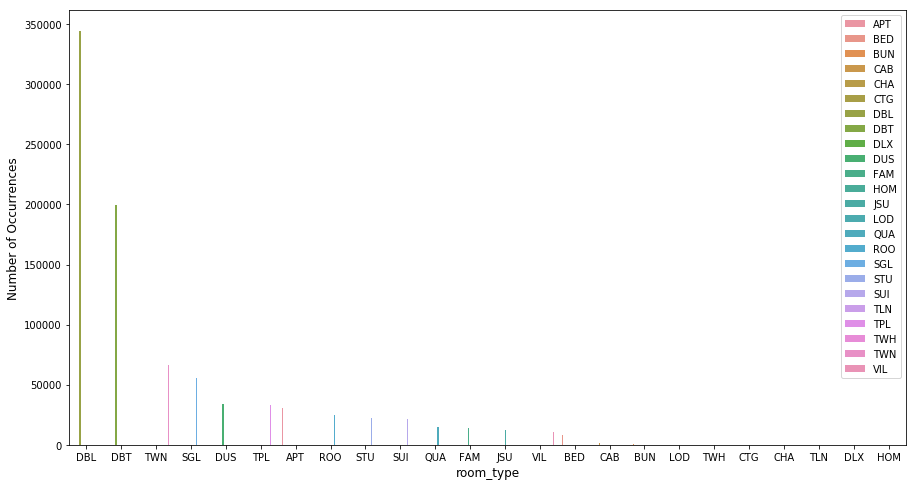

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'meal_basis')

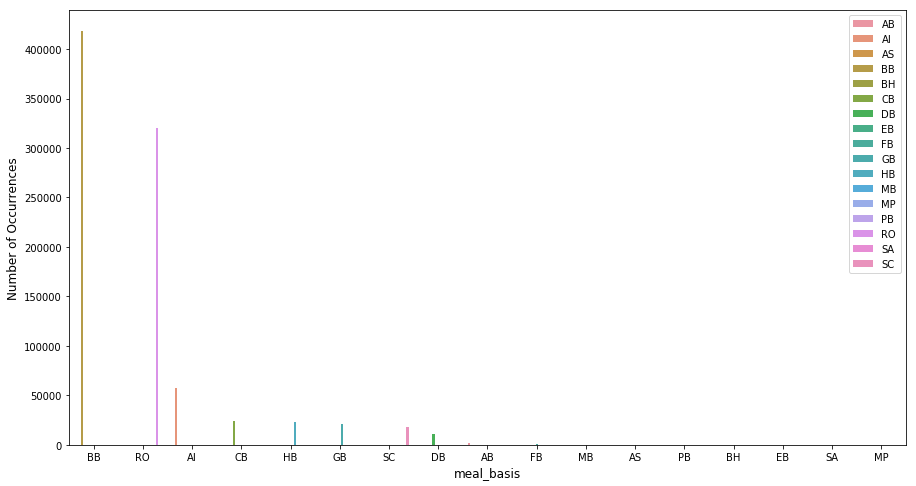

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'star_rating')

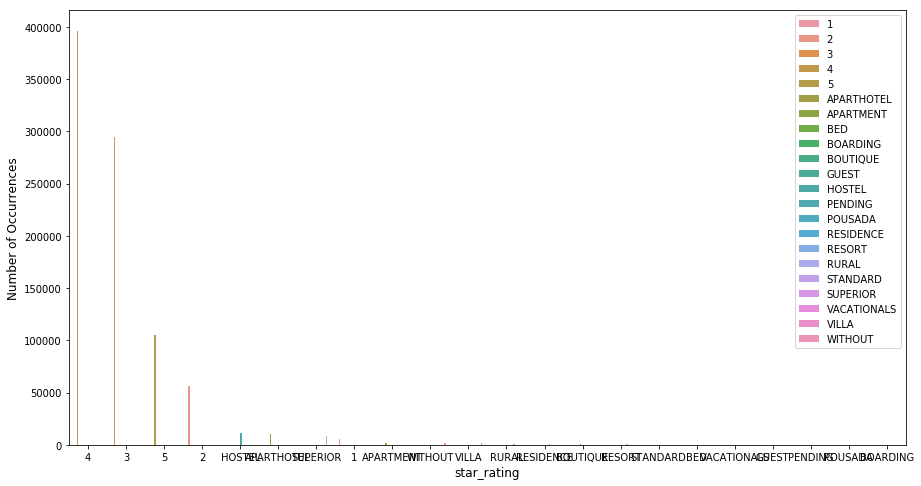

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'creation_date_month')

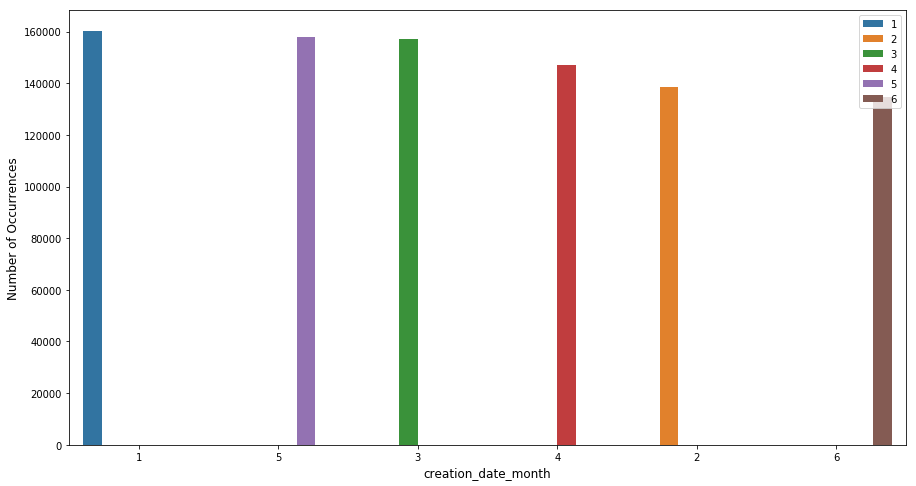

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'creation_date_day')

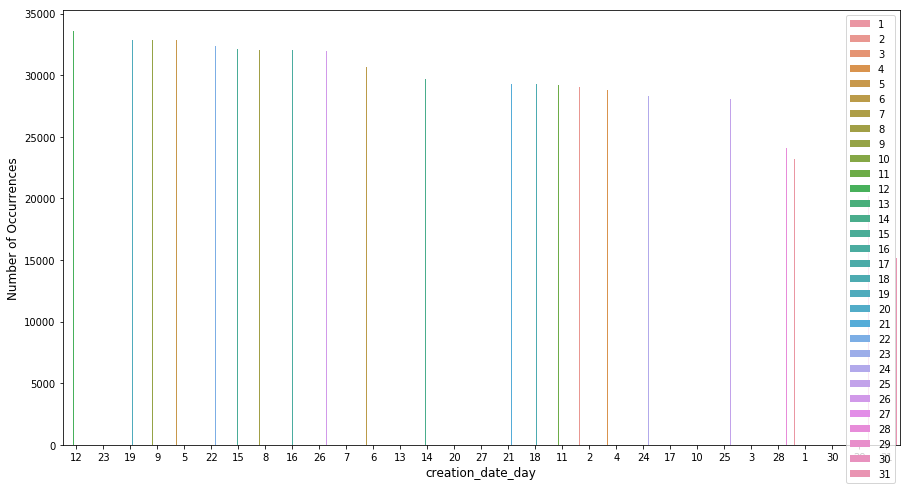

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'creation_date_weekday')

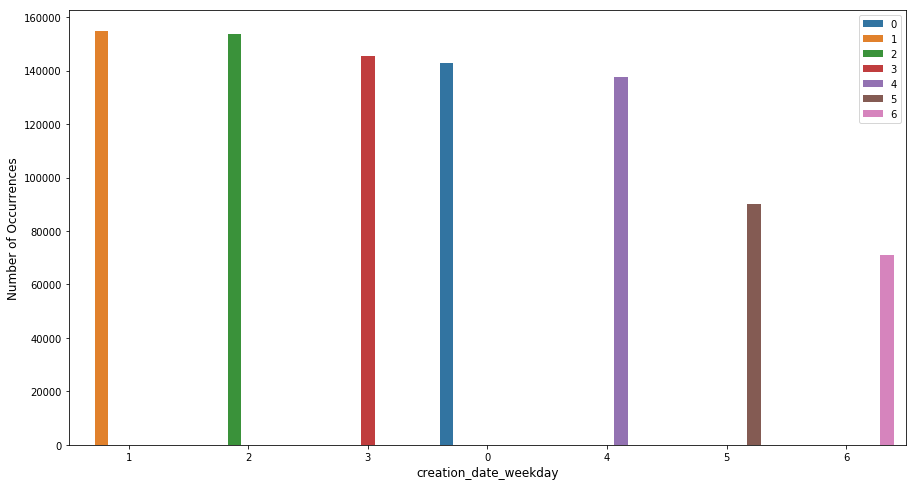

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'arrival_date_month')

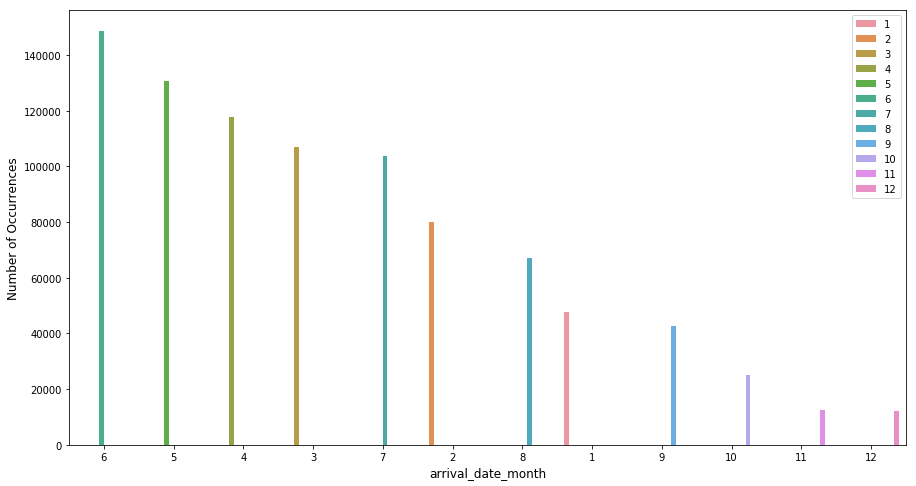

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'arrival_date_day')

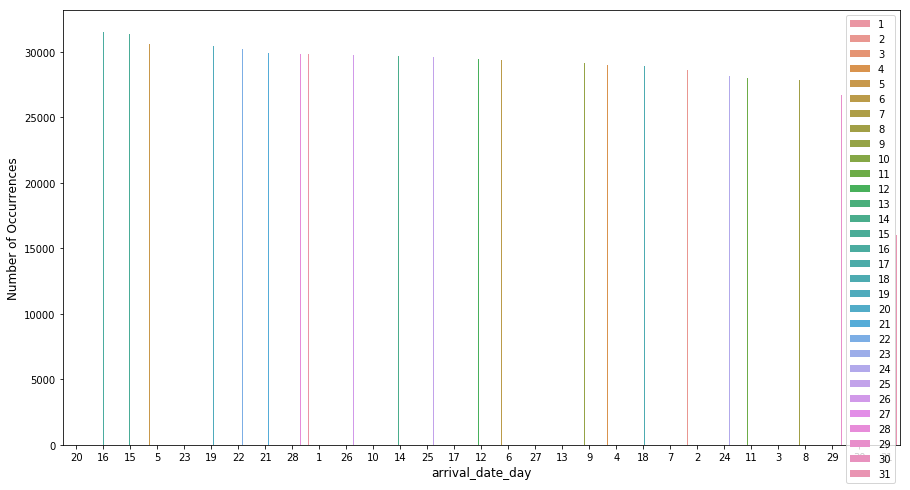

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'arrival_date_weekday')

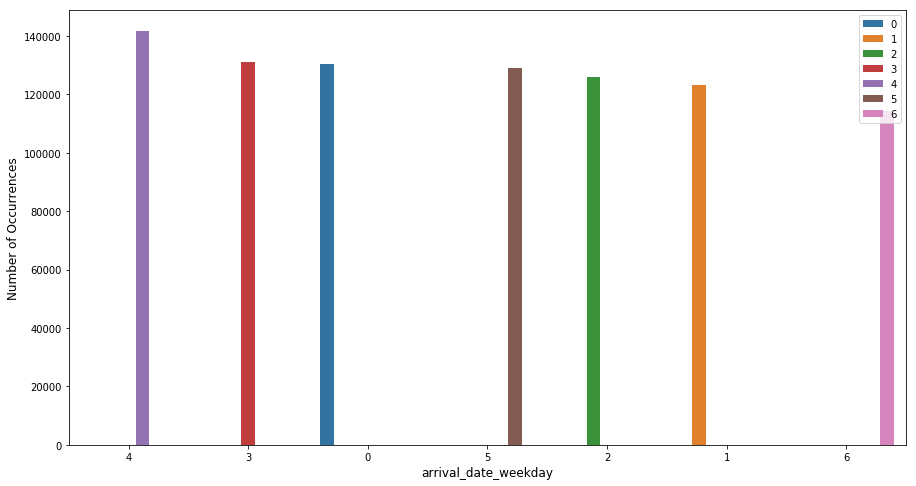

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'departure_date_month')

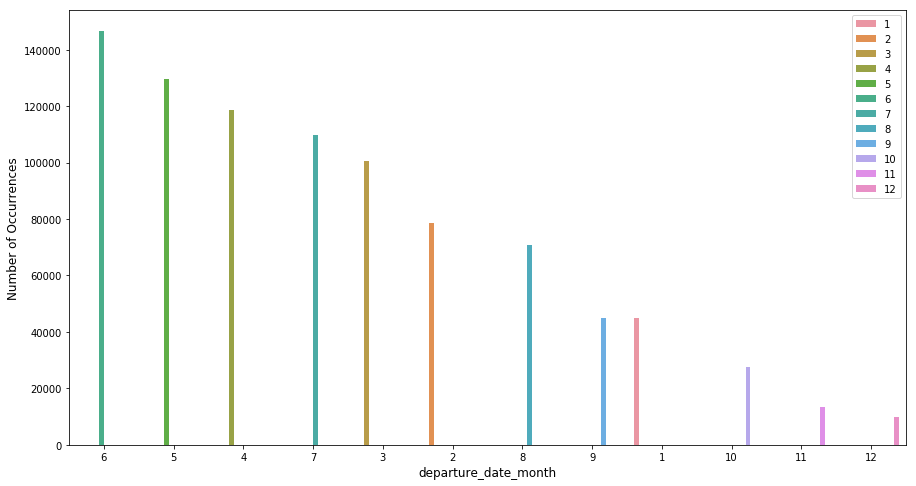

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'departure_date_day')

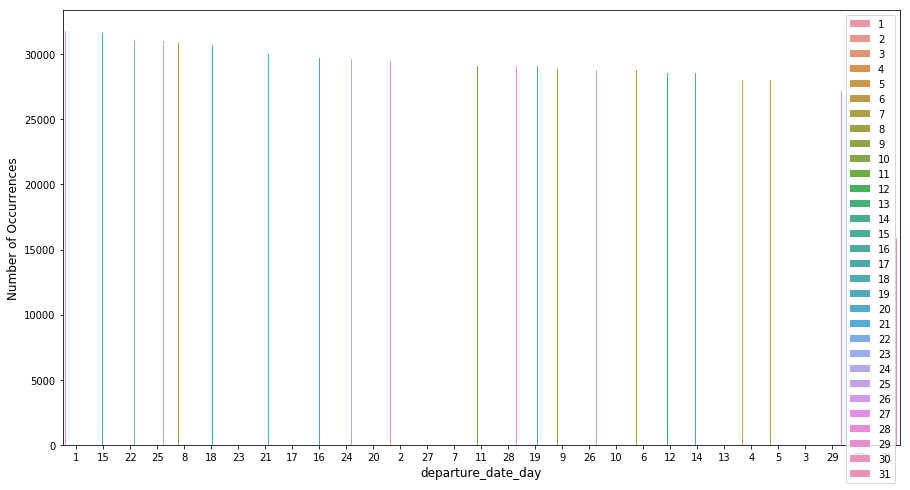

<Figure size 1080x576 with 0 Axes>

Text(0,0.5,'Number of Occurrences')

Text(0.5,0,'departure_date_weekday')

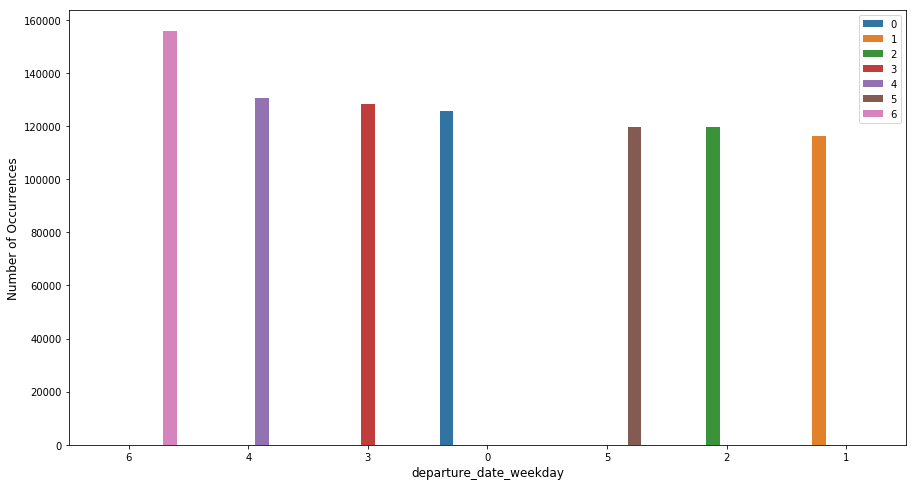

In [15]:
# Visualize the count of occurrences by categories
for i,col in enumerate(categoricalVariables):
    plt.figure(i,figsize=(15,8))
    sns.countplot(df[col],hue = df[col], order=df[col].value_counts().index)
    plt.legend(loc='upper right')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.show()

We can see here that for many of the categorical variables the distribution/ count is extremely skewed towards a minor group of categories (levels). This provides some evidence to our hypothesis that low count categories with out of normal range prices may be anomalous in nature. Alternatively they can be realistic outliers and not anomalies.

<Figure size 1080x576 with 0 Axes>

/Users/miketondu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


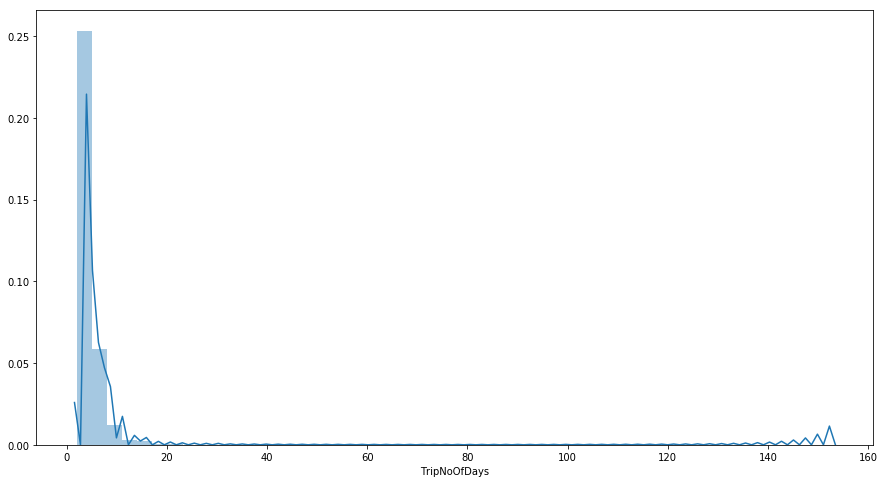

<Figure size 1080x576 with 0 Axes>

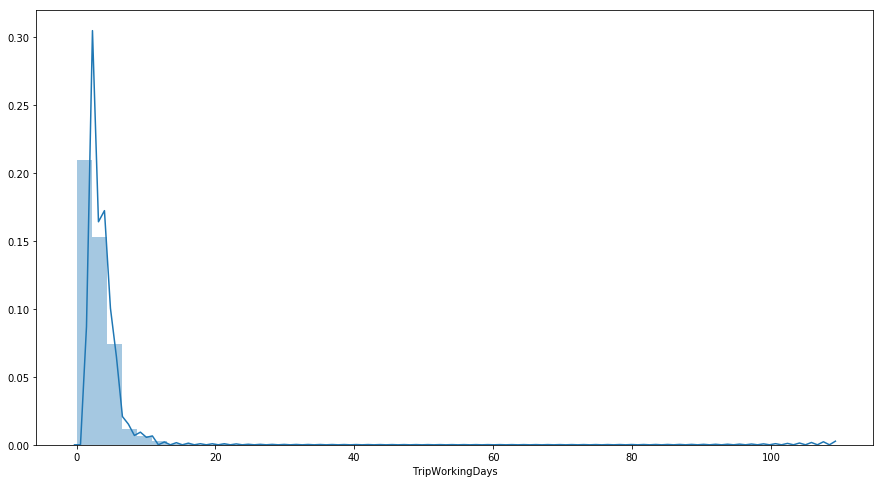

<Figure size 1080x576 with 0 Axes>

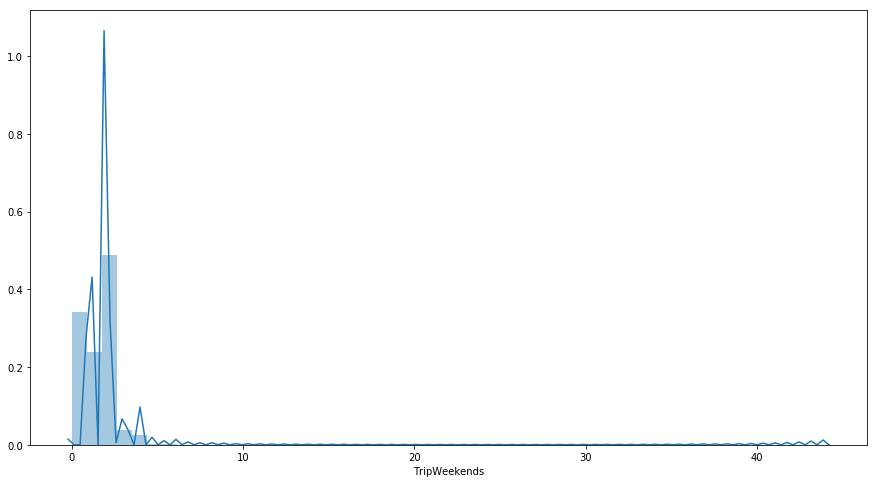

<Figure size 1080x576 with 0 Axes>

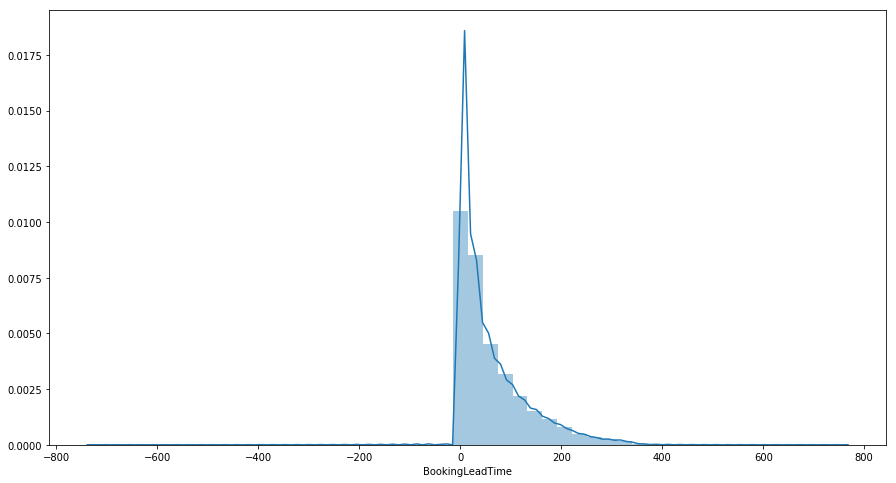

<Figure size 1080x576 with 0 Axes>

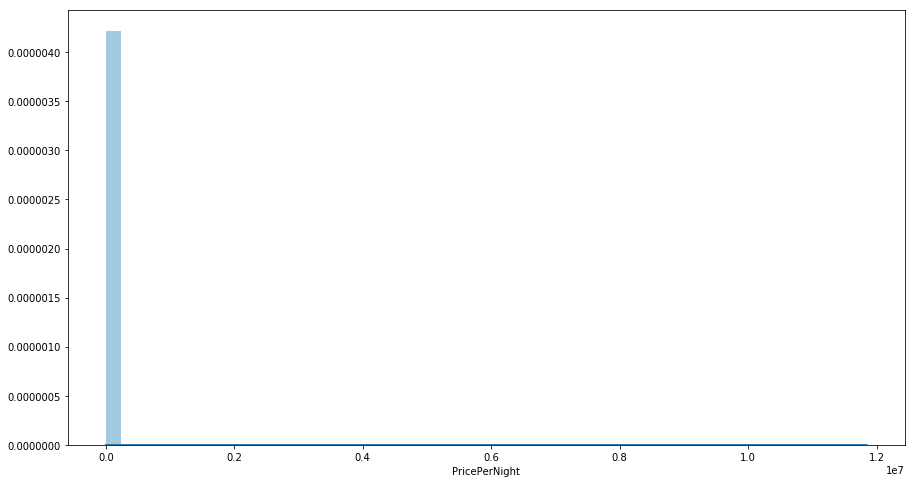

In [16]:
# Plot the distribution of the numerical variables 
for i, col in enumerate(numericalVariables):
    plt.figure(i, figsize=(15,8))
    sns.distplot(df.loc[:,col])  
    plt.show()

In booking lead time, we can observe a left tail corresponding to negative lead times, which are anomalies. However, these anomalies are not price related, this is why we will not include them in the final prediction.

In [17]:
# Description of the price per nigt variable and the cut-off point of the 99.995 percentile
print(df.PricePerNight.describe())
print(np.percentile(df.PricePerNight, 99.995))

count    8.959580e+05
mean     1.198483e+03
std      1.283416e+04
min      0.000000e+00
25%      5.070000e+02
50%      8.870000e+02
75%      1.495000e+03
max      1.184651e+07
Name: PricePerNight, dtype: float64
26555.115900011268


In [18]:
# Number of the points on the left of the 0.005 percentile
print(np.percentile(df.PricePerNight, 0.005))

37.0


###### We see that the skew is denser upto 99%ile and becomes sparse at higher percentiles. Using basic statistical concepts related to normal distribution, we can assume price values above 99.995% lie as outliers with higher confidence levels. The same statistical rule can be applied on the lower side of the price band.

In [19]:
# Number of the points on the left of the 0.01 percentile OR on the right of the 99.995 percentile
df.loc[(df.PricePerNight > np.percentile(df.PricePerNight, 99.995)) | (df.PricePerNight < np.percentile(df.PricePerNight, 0.01)) , :].shape

(113, 23)

In [20]:
# Saving the previous instances into a new Data Frame
df_anomaly2 = df.loc[(df.PricePerNight > np.percentile(df.PricePerNight, 99.995)) | (df.PricePerNight < np.percentile(df.PricePerNight, 0.01)) , :]
df = df.loc[(df.PricePerNight < np.percentile(df.PricePerNight, 99.995)) & (df.PricePerNight > np.percentile(df.PricePerNight, 0.01)) , :]
df.shape
df_anomaly2.describe()

(895809, 23)

,hotel_hkey,contract_id_hkey,row_id,TripNoOfDays,TripWorkingDays,TripWeekends,BookingLeadTime,PricePerNight
count,1.130000e+02,1.130000e+02,113.000000,113.000000,113.000000,113.000000,113.000000,1.130000e+02
mean,5.170724e+17,1.149139e+17,474810.716814,7.893805,5.619469,2.274336,65.451327,1.641271e+05
std,5.207845e+18,5.244763e+18,255850.701450,18.495348,13.101471,5.446571,89.509476,1.131760e+06
min,-9.200601e+18,-9.138076e+18,2774.000000,2.000000,0.000000,0.000000,-211.000000,0.000000e+00
25%,-4.096745e+18,-4.249389e+18,278740.000000,2.000000,2.000000,0.000000,7.000000,3.600000e+01
50%,6.811305e+17,-8.859426e+16,485717.000000,2.000000,2.000000,1.000000,36.000000,3.900000e+01
75%,5.093733e+18,4.791879e+18,687226.000000,6.000000,5.000000,2.000000,92.000000,3.132900e+04
max,9.154176e+18,9.113215e+18,899298.000000,153.000000,109.000000,44.000000,361.000000,1.184651e+07


In [21]:
# Count of anomalies inside the dataframe 'df_anomaly2'
df_anomaly2.contract_id_hkey.unique().size

113

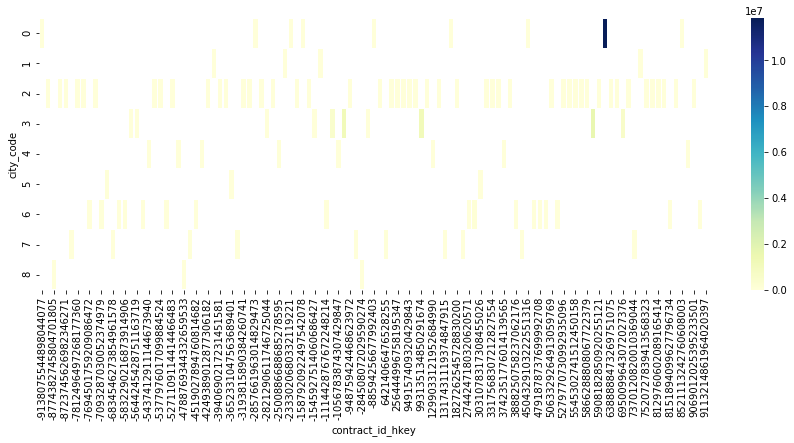

In [22]:
# Heatmap of the cities per hotel against its price
plt.figure(figsize=(15,5))
sns.heatmap(df_anomaly2.groupby(["city_code", "contract_id_hkey"])['PricePerNight'].min().unstack()
            ,linewidths=.5, cmap="YlGnBu");

Clearly they are mostly outliers among this sub data set. For now we can treat them as anomalies.

<Figure size 720x432 with 0 Axes>

Text(0,0.5,'PricePerNight')

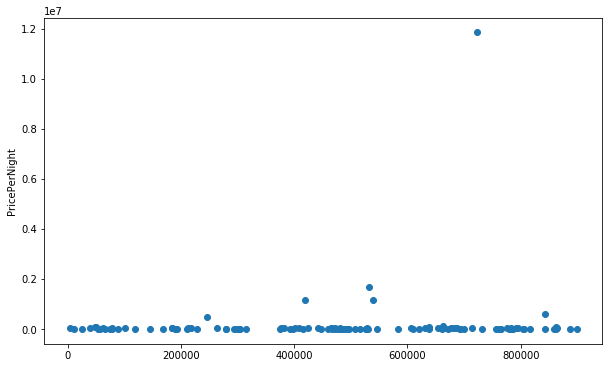

In [23]:
# Scatter plot of the anomalies compressed per night in the Data Frame 'df_anomaly2'
plt.figure(figsize=(10,6))
plt.scatter(df_anomaly2.index,df_anomaly2.PricePerNight)
plt.ylabel('PricePerNight')

In [24]:
# Saving the prepared df for future exploration
df.to_csv('clean_datathon_stu.csv')